In [106]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Analysis and Cleaning

In this notebook, we will try to clean and analyse the data before applying the Machine Learning algorithm. 

First, we need to load the data.

In [2]:
df = pd.read_csv('./data/CrowdstormingDataJuly1st.csv')
print(df.shape)
df.head(5)

(146028, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Is `playerShort` a unique key ??

As `playerShort` does not have a clear name defining it as a unique key for player, we want to ensure that it is the case. 

To do so, we will aggregate the `playerShort` with the birthday and check how many occurencies we have. If it is not a unique key, indeed, we will see a difference between number of `playerShort` and number of `playerShort`-`birthday`


In [35]:
print("number of unique playerShort: ", df['playerShort'].unique().shape[0])
print("number of unique playerShort and birthday: ", df.groupby(['playerShort', 'birthday']).size().count())

number of unique playerShort:  2053
number of unique playerShort and birthday:  2053


The `playerShort`field is, indeed, a unique ID for players.

We can see below that it deals with players having the same name by adding an extra number, which make `playerShort` a unique key.

In [36]:
df.loc[df["playerShort"].str.contains("abdoulaye-diallo")]['playerShort'].unique()

array(['abdoulaye-diallo_2', 'abdoulaye-diallo_3'], dtype=object)

## Remove non-aggregating column

In [69]:
# really useless column
col_to_remove = ['photoID']
# columns impossible to aggregate, because represent information on referee
col_to_remove += ['refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']
# name is already contained in playerShort
col_to_remove += ['player']
df_clean = df.drop(col_to_remove, axis=1)
df_clean.shape

(146028, 17)

In [90]:
# will take first value of the grouped data
sole_value = lambda x : list(x)[0]

#dictionary that maps columns to aggregation functions
agg_funcs = {'club' : sole_value, 'leagueCountry' : sole_value, 'birthday' : sole_value, \
             'height' : sole_value,'weight' : sole_value,'position' : sole_value, \
             'rater1' : sole_value, 'rater2' : sole_value, \
            'games' : sum, 'victories' : sum, 'ties' : sum, \
            'defeats' : sum, 'goals' : sum, 'yellowCards' : sum, \
             'yellowReds' : sum, 'redCards' : sum}

#group and aggregate
df_player = df_clean.groupby('playerShort', as_index = True).agg(agg_funcs)

# df_player = df_clean.groupby(['playerShort', 'club', 'leagueCountry', 'birthday', 'height', 'weight', 'position', \
#                               'rater1', 'rater2']).sum()

# df_player = df_clean.groupby(['playerShort']).sum()
print("shape: ", df_player.shape)
df_player.head(5)

shape:  (2053, 16)


,ties,victories,rater1,defeats,yellowCards,club,rater2,yellowReds,birthday,height,redCards,leagueCountry,goals,weight,games,position
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,179,247,0.25,228,19,Fulham FC,0.00,0,08.11.1979,182.0,0,England,9,71.0,654,Center Back
aaron-hunt,73,141,0.00,122,42,Werder Bremen,0.25,0,04.09.1986,183.0,1,Germany,62,73.0,336,Attacking Midfielder
aaron-lennon,97,200,0.25,115,11,Tottenham Hotspur,0.25,0,16.04.1987,165.0,0,England,31,63.0,412,Right Midfielder
aaron-ramsey,42,150,0.00,68,31,Arsenal FC,0.00,0,26.12.1990,178.0,1,England,39,76.0,260,Center Midfielder
abdelhamid-el-kaoutari,40,41,0.25,43,8,Montpellier HSC,0.25,4,17.03.1990,180.0,2,France,1,73.0,124,Center Back


In [95]:
df_player_color = df_player
# true for dark skin; false for white skin
df_player_color['skin_colour'] = df_player_color[['rater1', 'rater2']].mean(axis=1) > 0.5
df_player_color = df_player_color.drop(['rater1', 'rater2'], axis=1)
print("shape: ", df_player_color.shape)
df_player_color.head(5)

shape:  (2053, 15)


,ties,victories,defeats,yellowCards,club,yellowReds,birthday,height,redCards,leagueCountry,goals,weight,games,position,skin_colour
playerShort,,,,,,,,,,,,,,,
aaron-hughes,179,247,228,19,Fulham FC,0,08.11.1979,182.0,0,England,9,71.0,654,Center Back,False
aaron-hunt,73,141,122,42,Werder Bremen,0,04.09.1986,183.0,1,Germany,62,73.0,336,Attacking Midfielder,False
aaron-lennon,97,200,115,11,Tottenham Hotspur,0,16.04.1987,165.0,0,England,31,63.0,412,Right Midfielder,False
aaron-ramsey,42,150,68,31,Arsenal FC,0,26.12.1990,178.0,1,England,39,76.0,260,Center Midfielder,False
abdelhamid-el-kaoutari,40,41,43,8,Montpellier HSC,4,17.03.1990,180.0,2,France,1,73.0,124,Center Back,False


In [167]:
# hide skin_color field for clustering
df_player_hidden = df_player_color.drop(['skin_colour'], axis=1)
df_player_hidden.head(3)

,ties,victories,defeats,yellowCards,club,yellowReds,birthday,height,redCards,leagueCountry,goals,weight,games,position
playerShort,,,,,,,,,,,,,,
aaron-hughes,179,247,228,19,Fulham FC,0,08.11.1979,182.0,0,England,9,71.0,654,Center Back
aaron-hunt,73,141,122,42,Werder Bremen,0,04.09.1986,183.0,1,Germany,62,73.0,336,Attacking Midfielder
aaron-lennon,97,200,115,11,Tottenham Hotspur,0,16.04.1987,165.0,0,England,31,63.0,412,Right Midfielder


## Preparing data for clustering

In [189]:
def replace_to_id(df, field):
    df[field] = df[field].astype('category').cat.codes

def keep_year(df):
    df['birthday'] = df['birthday'].astype(str).str[6 :].astype(np.int16)
    
def replace_nan_by_mean(df, field):
    df[field] = df[field].fillna((df[field].mean()), inplace = False)
    
df_player_to_id = pd.DataFrame.copy(df_player_hidden)
df_player_to_id = df_player_to_id.reset_index()
replace_to_id(df_player_to_id, 'club')
replace_to_id(df_player_to_id, 'leagueCountry')
replace_to_id(df_player_to_id, 'position')
keep_year(df_player_to_id)
replace_nan_by_mean(df_player_to_id, 'height')
replace_nan_by_mean(df_player_to_id, 'weight')
df_player_to_id = df_player_to_id.drop('playerShort', axis=1)
df_player_to_id.head(5)

,ties,victories,defeats,yellowCards,club,yellowReds,birthday,height,redCards,leagueCountry,goals,weight,games,position
0,179,247,228,19,42,0,1979,182.0,0,0,9,71.0,654,1
1,73,141,122,42,110,0,1986,183.0,1,2,62,73.0,336,0
2,97,200,115,11,100,0,1987,165.0,0,0,31,63.0,412,10
3,42,150,68,31,8,0,1990,178.0,1,0,39,76.0,260,3
4,40,41,43,8,62,4,1990,180.0,2,1,1,73.0,124,1


In [190]:
X = df_player_to_id.as_matrix()


In [193]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.cluster_centers_)
kmeans.labels_


[[  9.05640194e+01   1.79011345e+02   1.13264182e+02   4.90826580e+01
    5.96839546e+01   1.34359806e+00   1.98281037e+03   1.81752026e+02
    1.55753647e+00   1.25769854e+00   5.01037277e+01   7.60729335e+01
    3.82839546e+02   3.97568882e+00]
 [  3.31093315e+01   5.30807799e+01   4.63725627e+01   1.80988858e+01
    5.77430362e+01   5.80083565e-01   1.98806616e+03   1.81740163e+02
    6.07938719e-01   1.48746518e+00   1.28495822e+01   7.54534616e+01
    1.32562674e+02   3.08495822e+00]]


array([0, 0, 0, ..., 0, 1, 1], dtype=int32)

In [23]:
df.groupby(['playerShort', 'birthday']).size().count()

2053

In [4]:
df.loc[df['playerShort'] == "john-utaka"]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
248,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,1,0,0,0,0,0,1663.jpg,0.75,0.75,12,6,MAR,0.322177,140.0,0.003344,0.117647,136.0,0.013721
269,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,1,0,0,1,0,0,1,1663.jpg,0.75,0.75,15,12,LBY,0.227627,19.0,0.019982,-0.111111,18.0,0.100631
382,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,0,0,0,1663.jpg,0.75,0.75,22,15,TUR,0.354707,656.0,0.000606,0.182081,692.0,0.002717
973,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,0,0,0,1663.jpg,0.75,0.75,66,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
1343,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,9,3,2,4,1,0,0,0,1663.jpg,0.75,0.75,67,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
2071,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,8,3,0,5,1,1,0,0,1663.jpg,0.75,0.75,77,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
4237,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,0,0,0,1663.jpg,0.75,0.75,119,56,GHA,0.070301,156.0,0.003202,-1.170455,176.0,0.013244
4642,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,4,2,2,0,0,0,0,0,1663.jpg,0.75,0.75,126,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
6544,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,1,0,0,0,0,0,0,1663.jpg,0.75,0.75,152,61,ARE,0.349778,831.0,0.000504,0.118510,886.0,0.002026


As it is explained in the Data Description (see `Data.md` in the *data* folder), the data are in a format called referee-player dyads. In other terms, each row is a dyad between a player and a referee, *i.e.* interaction between a player and a referee. 

## Clean the NaNs values for the colors of players

Let's print the columns and the size;

In [86]:
print(df.columns)
print(df.shape)

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')
(146028, 28)


First, we can clean the skin color columns. To do so, we remove all the lines with NaN in *rater1* and *rater2* columns.

In [87]:
df = df.dropna(subset=['rater1', 'rater2'])
print(df.shape)
df.head(10)

(124621, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0,0,0,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0,0,0,0,36499.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
10,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,0,0,0,1,0,0,59786.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
11,ashkan-dejagah,Ashkan Dejagah,Fulham FC,England,05.07.1986,181.0,74.0,Left Winger,1,1,0,0,0,0,0,0,23229.jpg,0.50,0.50,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
12,benedikt-hoewedes,Benedikt Höwedes,FC Schalke 04,Germany,29.02.1988,187.0,80.0,Center Back,1,1,0,0,0,0,0,0,59387.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [88]:
# Check for other null values
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID          False
rater1           False
rater2           False
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

In [89]:
df[df['meanIAT'].isnull()].shape

(153, 28)

In [90]:
df[df['meanExp'].isnull()].shape

(153, 28)

In [91]:
df[df['meanExp'].isnull()].Alpha_3.unique()

array(['QAT  ', 'ANT', 'Mali', nan, 'NAM'], dtype=object)

Let's just remove the few referees which haven't any values for the *meanExp* and the *meanIAT*. 

In [92]:
df = df[~df['meanExp'].isnull()]
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID          False
rater1           False
rater2           False
refNum           False
refCountry       False
Alpha_3          False
meanIAT          False
nIAT             False
seIAT            False
meanExp          False
nExp             False
seExp            False
dtype: bool

We can see here that there are a lot of columns with Nans values. But we will deal with them later. =)

## Create the skin_colour column

We define the skin_colour column as the mean of the *rater1* and *rater2* columns.

rater1 summary:
count    124468.000000
mean          0.264070
std           0.295304
min           0.000000
25%           0.000000
50%           0.250000
75%           0.250000
max           1.000000
Name: rater1, dtype: float64
rater2 summary:
count    124468.000000
mean          0.302682
std           0.292933
min           0.000000
25%           0.000000
50%           0.250000
75%           0.500000
max           1.000000
Name: rater2, dtype: float64


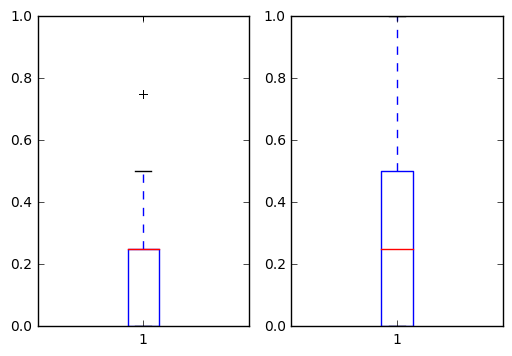

rater1 summary:
count    1.244680e+05
mean     5.157398e-18
std      1.000000e+00
min     -8.942318e-01
25%     -8.942318e-01
50%     -4.764548e-02
75%     -4.764548e-02
max      2.492114e+00
Name: rater1, dtype: float64
rater2 summary:
count    1.244680e+05
mean    -4.171070e-15
std      1.000000e+00
min     -1.033281e+00
25%     -1.033281e+00
50%     -1.798439e-01
75%      6.735934e-01
max      2.380468e+00
Name: rater2, dtype: float64


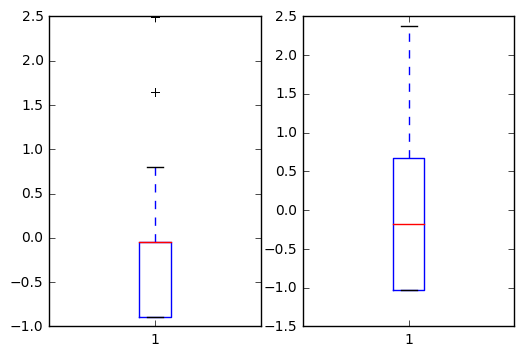

In [93]:
print("==================")
print("rater1 summary:")
print(df['rater1'].describe())

print("==================")
print("rater2 summary:")
print(df['rater2'].describe())

f, axarr = plt.subplots(1, 2)
axarr[0].boxplot(df['rater1'])
axarr[1].boxplot(df['rater2'])
plt.show()

cols_to_norm = ['rater1','rater2']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.mean()) / pd.Series.std(x))


print("==================")
print("rater1 summary:")
print(df['rater1'].describe())

print("==================")
print("rater2 summary:")
print(df['rater2'].describe())

f, axarr = plt.subplots(1, 2)
axarr[0].boxplot(df['rater1'])
axarr[1].boxplot(df['rater2'])
plt.show()

In [94]:
df['skin_colour'] = df[['rater1', 'rater2']].mean(axis=1)
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,-0.047645,0.673593,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.312974
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,1.645527,1.527031,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1.586279
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,-0.047645,-1.033281,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,-0.540463
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,-0.894232,-0.179844,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,-0.537038
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,2.492114,2.380468,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,2.436291


We can remove the columns *rater1* and *rater2* and rescale skin_color between 0 and 1

In [95]:
df = df.drop(['rater1', 'rater2'], axis=1)

cols_to_norm = ['skin_colour']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375504
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750000
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.124496
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125504
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000000


In [96]:
# Just check the unique values for the skin_colour column
unique_colours = df['skin_colour'].unique()
unique_colours

array([ 0.37550374,  0.75      ,  0.12449626,  0.12550374,  1.        ,
        0.25      ,  0.        ,  0.5       ,  0.87550374,  0.62550374,
        0.62449626,  0.87449626,  0.37449626,  0.25100747])

## Remove other columns

Now, we want to remove some useless columns. 

In [21]:
print(df.columns)

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'refNum',
       'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp',
       'seExp', 'skin_colour'],
      dtype='object')


We can remove the foloowing columns:
- *photoID*: We don't need it since we don't have the picture. =)
- *refNum*: We will aggregate the values with the name of the player.
- *refCountry*: We will aggregate the values with the name of the player.
- *Alpha_3*: We will aggregate the values with the name of the player.

We can also remove all the following columns since they concern only a specific referee:
- *meanIAT*
- *nIAT*
- *seIAT*
- *meanExp*
- *nExp*
- *seExp*

**We are maybe removing too much columns. So, we will have to decide if we keep them (if we don't aggregate for example). Or we can also scrap some website with stats on football players to get more stats on them**

In [26]:
#col_to_remove = ['photoID', 'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']
col_to_remove = ['photoID', 'refNum', ]
df_clean = df.drop(col_to_remove, axis=1)

In [27]:
print(df_clean.shape)
df_clean.head(10)

(124468, 17)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,1.000
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0,0,0,0,0.250
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0,0,0,0,0.000
10,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,0,0,0,1,0,0,0.000
11,ashkan-dejagah,Ashkan Dejagah,Fulham FC,England,05.07.1986,181.0,74.0,Left Winger,1,1,0,0,0,0,0,0,0.500
12,benedikt-hoewedes,Benedikt Höwedes,FC Schalke 04,Germany,29.02.1988,187.0,80.0,Center Back,1,1,0,0,0,0,0,0,0.000


We now have 17 columns. We can now aggregate on the name of the players.

## Aggregation of the table

First, let's check the number of different players. There are players with same first and last name, so we build a unique identifier concatenating name and birthday.

In [28]:
df_clean['name_date'] = df['playerShort']+df['birthday']

In [29]:
print("Total number of players: ", len(df_clean['name_date'].unique()))

Total number of players:  1585


In [30]:
unique_players = df_clean['name_date'].unique()

In [31]:
df_players = pd.DataFrame([], columns = df_clean.columns)
df_players.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_colour,name_date


In [32]:
# Values we want to sum
summed = ['games', 'victories', 'ties', 'defeats', 'goals', 
          'yellowCards', 'yellowReds', 'redCards']

idx = 0
for plyr in unique_players:
    # Get all entries with the same player
    df_player = df_clean[df_clean['name_date'] == plyr]
    df_player.index = np.arange(len(df_player))
    # Sum the numbers
    sum_values = df_player.sum(numeric_only=True)

    # Create the array for the player
    array_player = []
    for i in df_clean.columns:
        if i in summed:
            array_player.append(sum_values[i])
        else:
            array_player.append(df_player[i][0])  
    
    # Add player to new DF
    df_players.loc[idx] = array_player
    idx += 1

In [33]:
df_players.tail()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_colour,name_date
1580,wesley-jobello,Wesley Jobello,Olympique Marseille,France,23.01.1994,179.0,68.0,Left Winger,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.750,wesley-jobello23.01.1994
1581,jerome-sinclair,Jerome Sinclair,Liverpool FC,England,20.09.1996,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750,jerome-sinclair20.09.1996
1582,momar-bangoura,Momar Bangoura,Olympique Marseille,France,24.02.1994,176.0,65.0,Defensive Midfielder,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.875,momar-bangoura24.02.1994
1583,kevin-osei,Kevin Osei,Olympique Marseille,France,26.03.1991,173.0,71.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.750,kevin-osei26.03.1991
1584,baptiste-aloe,Baptiste Aloe,Olympique Marseille,France,29.06.1994,184.0,77.0,Center Back,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.250,baptiste-aloe29.06.1994


Now, we can save this first DataFrame.

In [34]:
df_players.to_csv('./data/players.csv', index=False)

## Let's check the remaining NaN

In [35]:
print("Percentage of people removed if we drop all na: ", 100*(1-df_players.dropna().shape[0]/df_players.shape[0]), "%%")

Percentage of people removed if we drop all na:  10.473186119873812 %%


Let's check the NA columns

In [36]:
df_players.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
skin_colour      False
name_date        False
dtype: bool

In [37]:
# Take someone with NA
df_players[df_players['height'] != df_players['height']]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_colour,name_date
1277,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,58.0,29.0,12.0,17.0,6.0,8.0,0.0,1.0,0.25,filip-malbasic18.11.1992
1393,loic-abenzoar,Loïc Abenzoar,Olympique Lyon,France,14.02.1989,NaN,NaN,Right Fullback,12.0,0.0,3.0,9.0,0.0,2.0,0.0,0.0,0.75,loic-abenzoar14.02.1989
1581,jerome-sinclair,Jerome Sinclair,Liverpool FC,England,20.09.1996,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,jerome-sinclair20.09.1996


In [38]:
# Let's check in the BIG DF
df[df['player'] == 'Filip Malbašić']

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour
3788,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,1,1,0,0,0,0,0,0,171196.jpg,101,51,SRB,0.282037,114.0,0.003725,0.420168,119.0,0.017657,0.25
14798,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,2,1,0,1,0,1,0,0,171196.jpg,305,42,KAZ,0.330980,72.0,0.005102,0.240506,79.0,0.038256,0.25
15152,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,1,0,0,1,0,0,0,0,171196.jpg,329,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225,0.25
20147,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,1,1,0,0,0,0,0,0,171196.jpg,385,51,SRB,0.282037,114.0,0.003725,0.420168,119.0,0.017657,0.25
20210,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,1,0,0,1,0,0,0,0,171196.jpg,392,51,SRB,0.282037,114.0,0.003725,0.420168,119.0,0.017657,0.25
29617,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,2,0,2,0,0,1,0,0,171196.jpg,548,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,0.25
34467,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,1,0,0,1,0,0,0,0,171196.jpg,616,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091,0.25
34652,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,1,0,0,1,0,1,0,0,171196.jpg,619,51,SRB,0.282037,114.0,0.003725,0.420168,119.0,0.017657,0.25
34658,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,2,1,0,1,0,0,0,0,171196.jpg,620,51,SRB,0.282037,114.0,0.003725,0.420168,119.0,0.017657,0.25
34966,filip-malbasic,Filip Malbašić,1899 Hoffenheim,Germany,18.11.1992,NaN,NaN,Left Winger,4,2,2,0,0,0,0,0,171196.jpg,627,51,SRB,0.282037,114.0,0.003725,0.420168,119.0,0.017657,0.25


We see that the values are always missing. Therefore, we remove the players with the missing values.

In [39]:
df_players_no_nan = df_players.dropna()

In [40]:
# Check for null values
df_players_no_nan.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height           False
weight           False
position         False
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
skin_colour      False
name_date        False
dtype: bool

No more null values. =)

Therefore, we can save this new csv.

In [41]:
df_players_no_nan.to_csv('./data/players_no_nan.csv', index=False)

## Cross-Featuring

We can introduce some cross-features with the features we removed. We know for example that the columns with
- **IAT** refer to the **race IAT test**, *i.e.* a high value correspond to someone who will prefer a white person (thinks it's a better person) over a black person.
- **Exp** refer to the use of a **racial thermometer task**, *i.e.* a high value correspond to greater feelings of warmth toward whites versus blacks.

If we want to keep these information, we can use the cross these information with the yellow and red cards. 

Let's introduce a **new variable**. We will call it the `gravity_factor`. It is given by:


\begin{equation}
G = Y + \frac{\sum Y}{\sum YR}  YR + \frac{\sum Y }{\sum R} R
\end{equation}
where:
- $Y$ is the number of yellow cards given to a player
- $\sum Y$ is the total number of yellow cards given
- $YR$ is the number of yellow then red cards given to a player
- $\sum YR$ is the total number of yellow then red cards given
- $R$ is the number of red cards given to a player
- $\sum R$ is the total number of red cards given


So, let's add this new value to the big DF.

In [42]:
print("Percentage of yellow cards: ", 100*df['yellowCards'].sum()/
      df['games'].sum(), "%")
print("Percentage of yellow then red cards: ", 100*df['yellowReds'].sum()/
      df['games'].sum(), "%")
print("Percentage of red cards: ", 100*df['redCards'].sum()/
      df['games'].sum(), "%")

Percentage of yellow cards:  13.33592576700279 %
Percentage of yellow then red cards:  0.4030787384681399 %
Percentage of red cards:  0.4261424586998498 %


In [43]:
nbr_yellow = df['yellowCards'].sum()
nbr_yellowRed = df['yellowReds'].sum()
nbr_red = df['redCards'].sum()

In [44]:
gravity = df['yellowCards'] + nbr_yellow/nbr_yellowRed * df['yellowReds'] + nbr_yellow/nbr_red * df['redCards']
gravity.unique()

array([   0.        ,    1.        ,   31.29452486,   33.08516301,
         32.29452486,    2.        ,    4.        ,    3.        ,
         35.08516301,   34.08516301,   34.29452486,    5.        ,
         38.08516301,   36.08516301,   11.        ,   71.17032601,
          6.        ,    8.        ,   43.08516301,   33.29452486,
         42.08516301,   69.37968787,    7.        ,   35.29452486,
         37.08516301,   40.08516301,   39.08516301,  111.46485087,
         65.37968787,   66.17032601,   38.29452486,   67.37968787,
        101.25548902,   36.29452486,   62.58904972,   66.37968787,
         64.37968787,   64.58904972,   67.17032601,    9.        ,
         68.17032601,   69.17032601,   70.17032601,   74.37968787,
         70.37968787,   37.29452486,   10.        ,   68.58904972,
         71.37968787,  101.67421272,   41.08516301,   63.58904972,
         99.67421272,   40.29452486,   39.29452486,   99.25548902,
         73.37968787,   44.08516301,   66.58904972,   46.08516

In [45]:
df_with_features = df
df_with_features['gravity'] = gravity
df_with_features.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour,gravity
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375,0.0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750,1.0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0.0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0.0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,0.0


In [46]:
gravity_players = df_players['yellowCards'] + nbr_yellow/nbr_yellowRed * df_players['yellowReds'] + nbr_yellow/nbr_red * df_players['redCards']

In [47]:
df_players_with_features = df_players
df_players_with_features['gravity'] = gravity_players
df_players_with_features.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_colour,name_date,gravity
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,144.0,65.0,32.0,47.0,10.0,21.0,1.0,2.0,0.375,lucas-wilchez31.08.1983,116.674213
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,427.0,183.0,101.0,143.0,88.0,33.0,0.0,2.0,0.750,john-utaka08.01.1982,95.589050
2,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,654.0,247.0,179.0,228.0,9.0,19.0,0.0,0.0,0.125,aaron-hughes08.11.1979,19.000000
3,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,285.0,138.0,57.0,90.0,28.0,50.0,4.0,3.0,0.125,aleksandar-kolarov10.11.1985,276.224227
4,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,214.0,88.0,54.0,72.0,11.0,34.0,0.0,0.0,1.000,alexander-tettey04.04.1986,34.000000


In [48]:
# Just check that the aggregation is correct
print("Gravity for 1st player in aggregated table: ", df_players_with_features['gravity'][0])
print("Gravity for 1st player in aggregated table: ", 
      df_with_features[df_with_features['player'] == 'Lucas Wilchez']['gravity'].sum())

# It's ok.. =)

Gravity for 1st player in aggregated table:  116.674212724
Gravity for 1st player in aggregated table:  116.6742127241217


We can now introduce another cross-features. The purpose this time is to use the *meanIAT* and *meanExp* values. To do so, we will link them with the 4 following features: *yellowCards*, *yellowReds*, *redCards*, and *gravity*. We will use the following equation:

\begin{equation}
F_{I-C} (P) = \frac{1}{\#R(P)} \sum_{r\in R(P)} \frac{C(r)}{E(r)} \cdot I(r)
\end{equation}

where:
- $F_{I-C} (P)$ defines the new feature.
- $I$ is the indicator. It can be *meanIAT* or *meanExp*
- $C$ defines the types of card received. It can be *yellowCards*, *yellowReds*, *redCards*, or *gravity*
- $P$ is a given player.
- $\#R(P)$ is the number of referees with whom a player played.
- $\sum_{r\in R(P)}$ is the sum over all referees who played with a given player.
- $C(r)$ is the value of $C$ for a specific Player and a specific referee.
- $E(r)$ is the number of times a referee played with a player.
- $I(r)$ is the indicator of the referee.

This will create 8 new features.

In [49]:
indicators = ['meanIAT', 'meanExp']
cards = ['yellowCards', 'yellowReds', 'redCards', 'gravity']

In [ ]:
for idcts in indicators:
    for crds in cards:
        feature_name = idcts + "_" + crds
        array_feature = []
        print("Start feature ", feature_name)
        for plyr in df_players['player']:
            feature = 0
            # Get the DF with the player
            df_player = df[df['player'] == plyr]
            # Number of different referee
            nbr_ref = len(df_player)
            # Reindex
            df_player.index = np.arange(nbr_ref)
            # Sum for the new feature
            for i in range(nbr_ref):
                feature += df_player[crds][i]/df_player['games'][i]*df_player[idcts][i]
            # Add it into the array
            array_feature.append(feature/nbr_ref)
        # Add it into the DataFrame
        df_players_with_features[feature_name] = array_feature
df_players_with_features.head()

Start feature  meanIAT_yellowCards


In [ ]:
# Let's save the new DF
df_players_with_features.to_csv('./data/players_with features.csv', index=False)

In [ ]:
# We can also save the one without the nan
df_players_with_features_no_nan = df_players_with_features.dropna()
df_players_with_features_no_nan.to_csv('./data/players_with features_no_nan.csv', index=False)

In [ ]:
# We can remove all the columns with String values instead of numerical values.
non_numeric = ['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'position']
df_players_with_features.drop(non_numeric, axis=1).to_csv('./data/players_with features_only_num_values.csv', index=False)
df_players_with_features_no_nan.drop(non_numeric, axis=1).to_csv('./data/players_with features_no_nan_only_num_values.csv', index=False)

## Visualization of the data

Let's do some scatter plot to see if some features are interesting with the *skin_colour*. We expect that some features such as the number of games played will be irrelevant with the *skin_colour*. 

In [ ]:
df_players_with_features_no_nan.shape

In [ ]:
features_tmp = df_players_with_features.columns
features = []
label = 'skin_colour'
for i in features_tmp:
    if i != 'skin_colour':
        features.append(i)
len(features)

In [ ]:
for ftre in features:
    if ftre not in non_numeric:
        plt.figure()
        plt.scatter(list(df_players_with_features_no_nan[ftre]), list(df_players_with_features_no_nan[label]))
        plt.title('Feature: %s'%(ftre))
        plt.xlabel(ftre)
        plt.ylabel(label)
        plt.show()

In [ ]:
# Just plot the values of meanExp because some values are less than 0
plt.figure()
plt.plot(df['meanExp'])
plt.plot(df['meanIAT'])

Mmmmhhhh

Seems that it will be difficul